# Pattern Recognition : CNN Example

We use the game library `pygame` to draw patterns on pictures.

`!pip install pygame`

In [ ]:
!pip install pygame
!pip install torchinfo
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 812 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 24.6 MB/s 


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torchvision  import models
from   torchinfo    import summary  
import pygame
pygame.init()

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


(3, 2)

## An example of drawing a picture

(128, 128, 3)


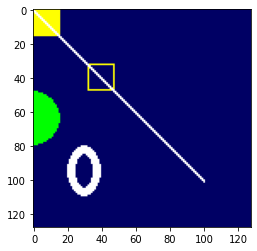

In [ ]:
image_size = (128, 128)                                            # width and height of the image
canvas = pygame.Surface(image_size)                                # create canvas for the image
  
canvas.fill( (0,0,100) )                                           # fill canvas with color (R,G,B)
pygame.draw.rect   (canvas,  (255,255,  0), (0, 0, 16,16) )        # color, (x0,y0, w, h)          - fill rect
pygame.draw.rect   (canvas,  (255,255,  0), (32, 32, 16,16), 1 )   # color, (x0,y0, w, h), line    - rect
pygame.draw.circle (canvas,  (  0,255,  0), (64, 0), 16 )          # color, (x0,y0), r             - fill circle
pygame.draw.ellipse(canvas,  (255,255,255), (80,20, 30,20), 5)     # color  (x0,y0,w,h), line
pygame.draw.line   (canvas,  (255,255,255), (0, 0), (100,100), 2)  # colot, (x1,y1), (x2,y2), line - line

ar = pygame.surfarray.array3d(canvas)                              # get RGB-array
print(ar.shape)
plt.imshow(ar)
plt.show()

## Toy dataset

Let's create a set of pictures with four types of patterns on them.

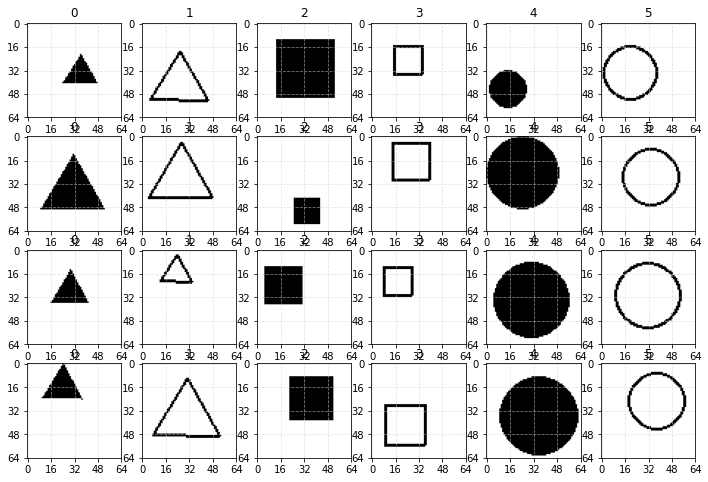

In [ ]:
NUM_EXAMPLES = 12000                          # number of examples
NUM_CLASSES  = 6                             # number of pattern classes
TRAIN_RATE   = 0.8                           # relative proportion of examples for training

IMAGE_SIZE   = (64, 64)                      # width and height of the image
SHAPE_SIZE   = (12, 28)                      # minimal and maximal size of pattern
ROTATE       = False

canvas = pygame.Surface(IMAGE_SIZE)

def shape(n, x0, y0, r, line = None, color = (255,255,255)):
    """regular polygon with n vertices """
    n = max(n, 3)
    phi0 = 2*np.pi/n
    phi  = phi0/2 if not ROTATE else np.random.rand()*np.pi    
    points = []
    for i in range(n):
        points.append( (x0 + r*np.cos(phi), y0 + r*np.sin(phi)) )
        phi += phi0
    if line: pygame.draw.polygon(canvas, color, points, line)
    else:    pygame.draw.polygon(canvas, color, points)

def circle(x0, y0, r, line = None, color = (255,255,255)):
    """ filled or outline circle """
    if line: pygame.draw.circle(canvas, color, (x0,y0), r, line)   
    else:    pygame.draw.circle(canvas, color, (x0,y0), r)   

def create_shapes(num_examples, repeat = 1, background = (0,0,0)):
    X, Y = [],[]
    for example in range(num_examples):           # generate examples
        for _ in range(repeat):
            canvas.fill( background )   
    
            r  = np.random.randint(SHAPE_SIZE[0], SHAPE_SIZE[1]) 
            x0 = np.random.randint(r, IMAGE_SIZE[0]-r)
            y0 = np.random.randint(r, IMAGE_SIZE[1]-r)    
        
            if    example % NUM_CLASSES == 0:    shape(3, x0,y0,r)
            elif  example % NUM_CLASSES == 1:    shape(3, x0,y0,r, 2)      
            elif  example % NUM_CLASSES == 2:    shape(4, x0,y0,r)                 
            elif  example % NUM_CLASSES == 3:    shape(4, x0,y0,r, 2)                 
            elif  example % NUM_CLASSES == 4:    circle(  x0,y0,r)              
            elif  example % NUM_CLASSES == 5:    circle(  x0,y0,r, 2)
            elif  example % NUM_CLASSES == 6:    shape(5, x0,y0,r)                 
            else:                                shape(5, x0,y0,r, 2)                 
        
            X.append(pygame.surfarray.array3d(canvas) )
            Y.append(example % NUM_CLASSES)
    return X,Y

X, Y = create_shapes(NUM_EXAMPLES)

plt.figure(figsize=(12, 8), facecolor ='w')                  
for i in range(24):    
    ax=plt.subplot(4, 6, i+1)    
    plt.title(f"{Y[i]}")
    
    plt.imshow(255-X[i], cmap='gray')  # inverse !!!
    ax.set_xticks(np.linspace(0, IMAGE_SIZE[0], 5 ))
    ax.set_yticks(np.linspace(0, IMAGE_SIZE[1], 5 ))
    ax.grid(color='lightgray', linestyle='--', alpha=0.6)    
plt.show()    

## Create training and test dataset

- Normalize Pixels to [0...1]
- Rreorder the indexes by putting the channel first: `(N, w,h,c) -> (N, c,w,h)`

In [ ]:
X,Y = np.array(X), np.array(Y)              # so faster creation of torch tensor
print("X:", X.shape, "  Y:", Y.shape)
X = X.mean(axis=3, keepdims=True)
print("X:", X.shape, "  Y:", Y.shape)

cnt_trn = int(len(X)*TRAIN_RATE)
X_trn = torch.tensor(X[:cnt_trn], dtype=torch.float32).permute(0, 3, 1, 2)/255.  # channel first, normalize
Y_trn = torch.tensor(Y[:cnt_trn], dtype=torch.int64)
X_tst = torch.tensor(X[cnt_trn:], dtype=torch.float32).permute(0, 3, 1, 2)/255.  # channel first, normalize
Y_tst = torch.tensor(Y[cnt_trn:], dtype=torch.int64)

print("X_trn:", X_trn.shape, "  Y_trn:", Y_trn.shape)
print("X_tst:", X_tst.shape, "  Y_tst:", Y_tst.shape)
print(X_trn[1])

X: (12000, 64, 64, 1)   Y: (12000,)
X: (12000, 64, 64, 1)   Y: (12000,)
X_trn: torch.Size([9600, 1, 64, 64])   Y_trn: torch.Size([9600])
X_tst: torch.Size([2400, 1, 64, 64])   Y_tst: torch.Size([2400])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


## Model

After the stack of cnn-layers, there is a fully connected layer with the number of outputs equal to the number of classes.<br> The dimension of its input is calculated in the constructor (`w`, `h`).

In [ ]:
class CNN(nn.Module):
    def __init__(self, 
                 shape   = (1, 64, 64),                                              # Input image shape (channels, height, width)        
                 outputs = 1,                                                        # Number of outpust 
                 channels = [], conv_kernels=[], conv_stride=1,  paddings=1, mode='replicate',      # Conv2d
                 batchnorm=False,                                                    # batchnorm
                 pool_kernel=2, pool_stride=2,  pool="max",         # Pooling
                 dropout=0.2,                                                        # Dropout
                 hiddens=None):                                                      # Add output hidden layers
        super(CNN, self).__init__()

        if paddings          == None: paddings    = 0                            # default
        if type(paddings)    == int:  paddings    = [paddings]   *len(channels)
        if conv_stride       == None: conv_stride = 1                            # default
        if type(conv_stride) == int:  conv_stride = [conv_stride]*len(channels)
        if pool_kernel       == None: pool_kernel = 2                            # default
        if type(pool_kernel) == int:  pool_kernel = [pool_kernel]*len(channels)    
        if type(pool_stride) == int:  pool_stride = [pool_stride]*len(channels)
        if not hiddens:               hiddens = []

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):
            if conv_kernels[i]:
                self.layers +=  [ 
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=conv_kernels[i], stride=conv_stride[i],  padding=paddings[i], padding_mode=mode),
                ]
                if batchnorm:                          # beetwen Line and non line   http://arxiv.org/pdf/1502.03167v2.pdf
                    self.layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
                self.layers += [ nn.ReLU() ]             

                h = int( (h + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)
                w = int( (w + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)  

            if pool_kernel[i] > 1:
                if pool == 'max': self.layers += [nn.MaxPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                else:             self.layers += [nn.AvgPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                h = int( (h - pool_kernel[i]) / pool_stride[i] + 1)
                w = int( (w - pool_kernel[i]) / pool_stride[i] + 1)            
                
        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w] + hiddens + [outputs]
        for i in range( len(hiddens)-1):
            if dropout > 0:        
                self.layers += [ nn.Dropout(p=dropout) ]
        
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                              # for probability after this need sigmoid (we used BCEWithLogitsLoss)
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res

In [ ]:
CFG = {
    'input':     (1,)+IMAGE_SIZE,
    'outputs':   NUM_CLASSES,
    'rotate':    ROTATE,
    'channels':  [2,2,2],
    'kernels':   [5,3,3],
    'strides':   [1,1,1],
    'paddings':  [2,1,1],
    'mode':      'replicate',   #'replicate', 'zeros'
    'pool_ker':  [2,2,2],
    'pool_str':  [2,2,2],
    'batchnorm': False,
    'dropout':   0.1,
    'batch':     512,
    'lr':        1e-4,   #!!!
    'L2':        1e-3,
    'hiddens':  []       #!!!
} 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN(shape = CFG['input'], outputs = CFG['outputs'],
            channels=CFG['channels'], conv_kernels=CFG['kernels'], conv_stride=CFG['strides'],  paddings=CFG['paddings'], mode=CFG['mode'],   # Conv2d        
            pool_kernel=CFG['pool_ker'], pool_stride=CFG['pool_str'],  pool="max",                               
            batchnorm=CFG['batchnorm'],                                                    # batchnorm
            dropout = CFG['dropout'],
            hiddens = CFG['hiddens'])

tot = 0
for k, v in model.state_dict().items():
    pars = np.prod(list(v.shape)); tot += pars
    print(f'{k:20s} :{pars:7d}  =  {tuple(v.shape)} ')
print(f"{'parameters':20s} :{tot:7d}")

model.to(device)

CFG['params'] = tot
summary(model, (1,1)+IMAGE_SIZE, col_names=["kernel_size", "output_size", "num_params"],) 


cuda:0
model.0.weight       :     50  =  (2, 1, 5, 5) 
model.0.bias         :      2  =  (2,) 
model.3.weight       :     36  =  (2, 2, 3, 3) 
model.3.bias         :      2  =  (2,) 
model.6.weight       :     36  =  (2, 2, 3, 3) 
model.6.bias         :      2  =  (2,) 
model.11.weight      :    768  =  (6, 128) 
model.11.bias        :      6  =  (6,) 
parameters           :    902


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
CNN                                      --                        [1, 6]                    --
├─Sequential: 1-1                        --                        [1, 6]                    --
│    └─Conv2d: 2-1                       [5, 5]                    [1, 2, 64, 64]            52
│    └─ReLU: 2-2                         --                        [1, 2, 64, 64]            --
│    └─MaxPool2d: 2-3                    2                         [1, 2, 32, 32]            --
│    └─Conv2d: 2-4                       [3, 3]                    [1, 2, 32, 32]            38
│    └─ReLU: 2-5                         --                        [1, 2, 32, 32]            --
│    └─MaxPool2d: 2-6                    2                         [1, 2, 16, 16]            --
│    └─Conv2d: 2-7                       [3, 3]                    [1, 2, 16, 16]            38
│    └─ReLU: 2-8                   

In [ ]:
model

CNN(
  (model): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (6): ReLU()
    (7): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=1280, out_features=6, bias=True)
  )
)

## Network learning

It is better to put all the training data in GPU memory. So it will be faster. However, with a large number of examples, memory may not be enough. Therefore, each batch is sent to memory.

In [ ]:
def fit(model, X,Y, batch_size=64, train=True, calc_L2 = False):         
    """ One epoch training """
    batch_size = min(batch_size, len(X))
    losses, accs = [], []
       
    idx = torch.randperm( len(X) )                      # permuted index list    
    X, Y = X[idx], Y[idx]      
    
    L2 = sum(p.data.pow(2).sum() for p in model.parameters()).cpu().item() if calc_L2 else -1
    
    model.train(train)                                  # important for Dropout, BatchNorm layers
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device) 
              
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
  
        #print(L, train)
        #print(y)

        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters

        #print("2")                                     

        losses.append(L.cpu().item())                   # total loss (item from graph)
        
        a = y.detach().argmax(axis=1)                   
        accs.append( (a == yb).float().mean().cpu().item() )  # class definition accuracy
         
    return np.mean(losses),  np.mean(accs), L2          # mean loss and accuracy

def smooth(x, beta=0.75):    
    av = np.copy(x)
    for i in range(1, len(x)):                
        av[i] = beta*av[i-1]+(1-beta)*x[i]        
    return av
    #return  np.convolve(x, np.ones(n)/n, mode='same')

def plot_train(history, alpha=0.3):
    """ Plot loss and accuarcy: history = [epoch, L_trn, L_tst, L2, A_trn, A_tst] """
    h = np.array(history)                               # learning output
    plt.figure(figsize=(16,5), facecolor ='w')              
    ax = plt.subplot(1, 2, 1);  
    plt.xlabel('epoch');  plt.ylabel('loss');  ax.set_title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")
    ax.set( ylim=(0, 0.5), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 1]), "-b")
    plt.plot(h[:,0], smooth(h[:, 2]), "-g")        
    ax.legend(['loss trn', 'loss tst'], loc='lower left')
    plt.plot(h[:,0], h[:, 1], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 2], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    ax2=ax.twinx()  
    ax2.plot(h[:,0], h[:,3], ":r"); ax2.set_ylabel('L2');   
    ax2.legend(['L2'], loc='center right')

    ax = plt.subplot(1, 2, 2);      
    plt.xlabel('epoch'); plt.ylabel('accuracy');  ax.set_title(f"acc_trn: {h[-1,4]:.4f}, acc_tst: {h[-1,5]:.4f}")
    ax.set( ylim=(0.5, 1.0), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 4]), "-b")
    plt.plot(h[:,0], smooth(h[:, 5]), "-g")
    ax.legend( ['acc trn', 'acc tst'], loc='lower left' )
    plt.plot(h[:,0], h[:, 4], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 5], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    
    pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
    ax.text(h[0,0]+(h[-1,0]-h[0,0])*0.5, 0.5, "".join(pars), {'fontsize':10, 'fontname':'monospace'})
    plt.show()

## Run training

before:      loss: 1.813471 accuracy: 0.166042
epoch:   500 loss: 0.087882 (0.076394) L2: 34.136547 accuracy: 0.969984 (0.980380)  4.22s

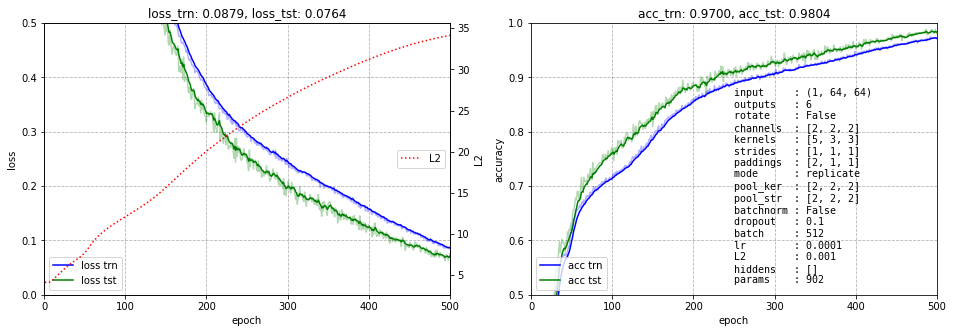

epoch:  1000 loss: 0.012046 (0.005257) L2: 34.979404 accuracy: 0.997636 (0.999756)  4.22s

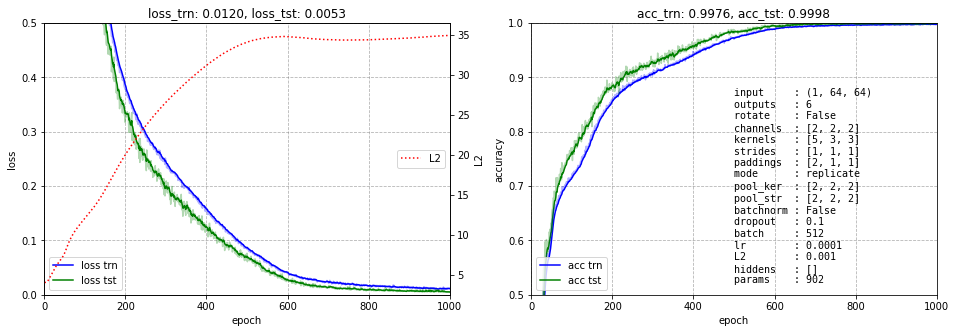

epoch:  1500 loss: 0.006033 (0.002579) L2: 35.627663 accuracy: 0.999075 (0.999756)  4.23s

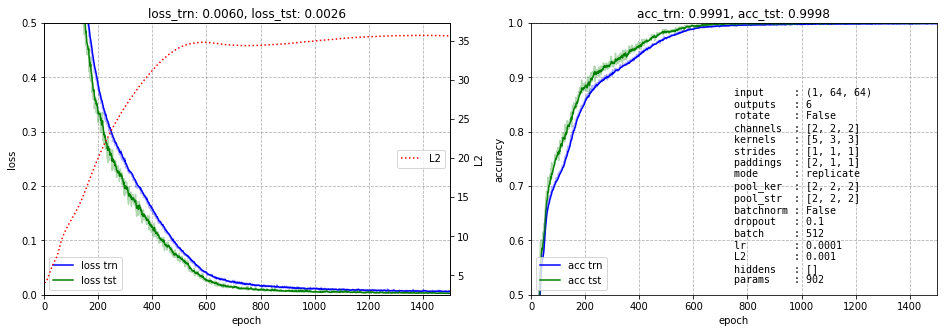

epoch:  1720 loss: 0.006075 (0.003417) L2: 35.238838 accuracy: 0.998732 (0.999756)  4.23s

KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache()

loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['L2'])   

epochs = 5000

model.to(device) # just in case
L_tst, A_tst, _ = fit(model, X_trn,Y_trn, batch_size=2048, train=False)
print( "before:      loss: %8.6f accuracy: %.6f" % (L_tst, A_tst)  )

history, losses, accs, beg = [], [], [], time.process_time()
for epoch in range(1, epochs+1):   
    
    L, A, L2 = fit(model, X_trn, Y_trn, batch_size=CFG['batch'], calc_L2=True)     # one epoch
    losses.append(L); accs.append(A)    

    if epoch % 1 == 0 or epoch == epochs:              # learning output   
        L_tst, A_tst, _ = fit(model, X_tst, Y_tst, batch_size=2048, train=False) 

    if epoch % 10 == 0:                                # learning output   
        print(f"\repoch: {epoch:5d} loss: {L:8.6f} ({L_tst:8.6f}) L2: {L2:.6f} accuracy: {A:.6f} ({A_tst:.6f})  {time.process_time()-beg:.2f}s", end="")           
        beg = time.process_time()                

    history.append([epoch, L, L_tst, L2, A, A_tst])

    if epoch % 500  == 0:
        plot_train(history)
                
plot_train(history)

## Plot wrong tests

0.0026441088023905954 0.9995833337306976
[876]
1


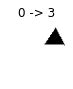

In [ ]:
def get_wrong(model, X,Y, batch_size=100):            
    batch_size = min(batch_size, len(X))      
    model.train(False)                                 # important for Dropout, BatchNorm layers
    wrong   = torch.tensor([], dtype=torch.int64)
    classes = torch.tensor([], dtype=torch.int64)
    sumL, sumA, numB = 0, 0, len(X) // batch_size      # error, accuracy, batches    
    for i in range(0, numB*batch_size, batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device)               

        y = model(xb)                                   # forward propagation         
        L = loss(y, yb) 

        sumL += L.item()                                # total loss (item from graph)
        
        a = y.argmax(axis=1)        
        sumA += (a == yb).float().mean().item()         # class definition accuracy
        
        classes = torch.cat([classes, a.cpu()], axis=0)        
        wrong   = torch.cat(  [wrong, i + (a != yb).cpu().nonzero(as_tuple=True)[0] ], axis=0  ) 
        
    return sumL/numB,  sumA/numB, wrong.numpy(), classes.numpy()       # mean loss, accuracy, errosrs

L, A, wrong, classes = get_wrong(model, X_tst,Y_tst, 200)
print(L,A)
print(wrong)

count = len(wrong)
print(count)
plt.figure(figsize=(16, 5))         
for i in range(count):    
    plt.subplot(4, count // 4 + 1, i+1)    
    plt.title(f"{Y_tst[wrong[i]]} -> {classes[wrong[i]]}")
    img = X_tst[wrong[i]].view(IMAGE_SIZE).long().numpy()
    plt.imshow( 1-img , cmap='gray')
    plt.axis('off')
plt.show()    

## Confusion matrix

total accuracy: 0.9995833333333334
classes accuracy: [0.9975 1.     1.     1.     1.     1.    ]


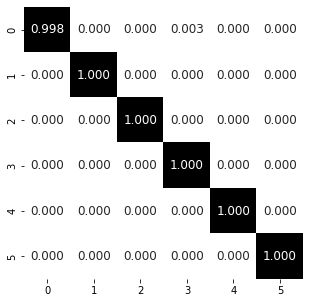

In [ ]:
from   sklearn.metrics import confusion_matrix
import seaborn as sn

matrix = confusion_matrix(Y_tst.numpy(), classes )

print("total accuracy:", matrix.diagonal().sum()/matrix.sum())
print("classes accuracy:", matrix.diagonal()/matrix.sum(axis=1))

matrix = matrix / matrix.sum(axis=1)
plt.figure(figsize = (5,5))
sn.heatmap(matrix, annot=True, cmap="Greys", annot_kws={"size": 12}, fmt=".3f", cbar=False)
plt.show()

## Feature maps

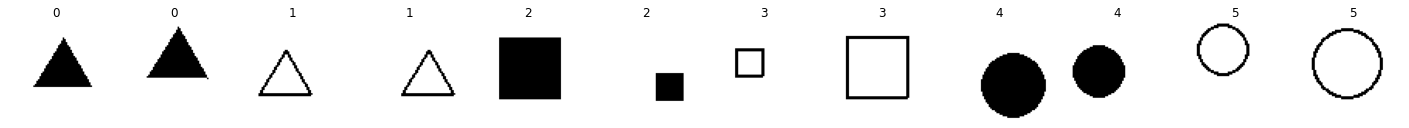

In [ ]:
N_images = NUM_CLASSES*2
X, Y = create_shapes(NUM_CLASSES, 2)
X = np.array(X).mean(axis=3, keepdims=True)

inp  = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)/255.  # channel first

plt.figure(figsize=(25, 5))                   # plot the 16 examples
for lv in range(1):
    for i in range(N_images):    
        plt.subplot(1, 12, i+1)    
        plt.title(f"{Y[i]}")
        plt.imshow(255-X[i].reshape(IMAGE_SIZE), cmap="gray")
        plt.axis('off')
plt.show()    

CNN(
  (model): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=128, out_features=6, bias=True)
  )
)
(12, 2, 8, 8)


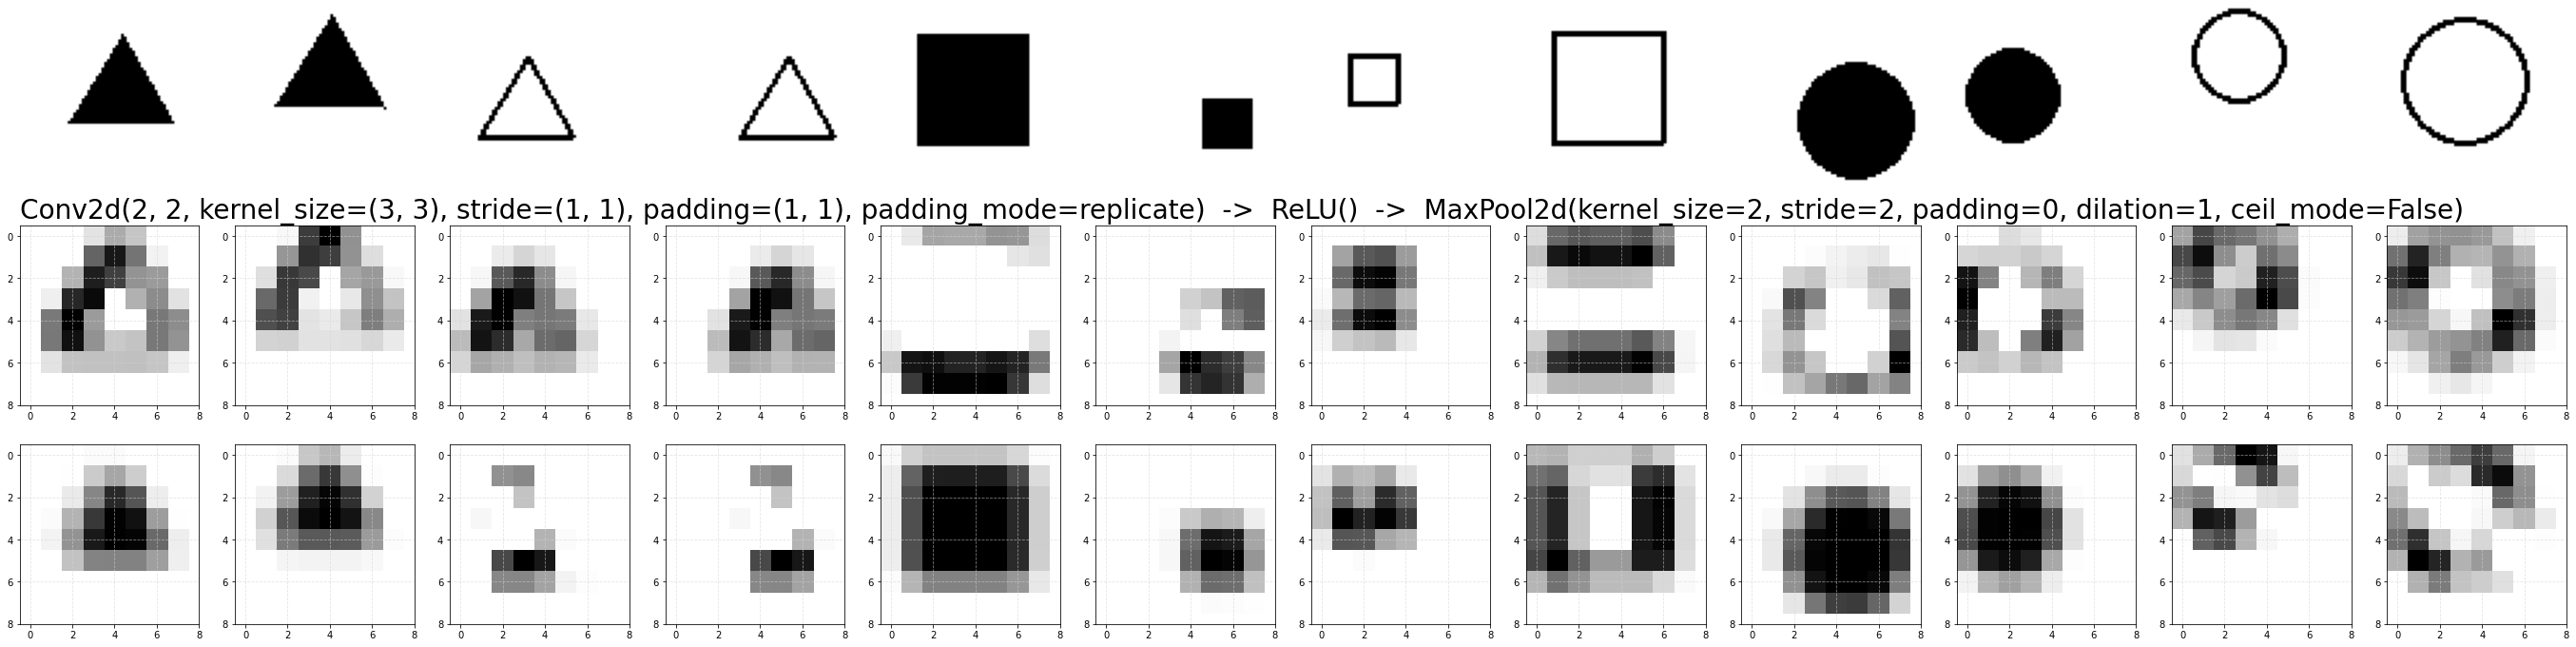

In [ ]:
print(model)
layers = model.get(inp.to(device))
layerID = [8]

num = 0
for i in range(len(layerID)):     # by layer
    layer = layers[layerID[i]]
    num += layer.shape[1]
    print(layer.shape)

tot = 1
plt.figure(figsize=(4*N_images, 4*(num+1)), facecolor ='w') 

for k in range(N_images):        # by image            
    plt.subplot(num+1, N_images, tot)        
    tot += 1            
    plt.imshow(255-X[k].reshape(IMAGE_SIZE), cmap="gray")
    plt.axis('off')

for i in range(len(layerID)):                # by layer
    layer = layers[layerID[i]]        
    for j in range(layer.shape[1]):          # by channel
        for k in range(N_images):        # by image
            ax = plt.subplot(num+1, N_images, tot)    
            tot += 1            
            if k == 0 and j == 0:
                plt.title(str(model.layers[layerID[i]-2]) + "  ->  " + str(model.layers[layerID[i]-1]) + "  ->  "+  str(model.layers[layerID[i]]), loc="left", fontsize=28)
            
            img = layer[k,j]
            plt.imshow(img.max()-img, cmap="gray", vmin = img.min(), vmax = img.max())  # "bwr"
            #ax.set( xlim=(0, img.shape[0]), ylim=(0, img.shape[1]) )
            ax.set_xticks(np.linspace(0, img.shape[0], 5 ))
            ax.set_yticks(np.linspace(0, img.shape[1], 5 ))
            ax.grid(color='lightgray', linestyle='--', alpha=0.6)
            

plt.show()   


In [ ]:
import shap

e = shap.DeepExplainer(model, X_tst.to(device))
shap_values = e.shap_values(inp.to(device))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


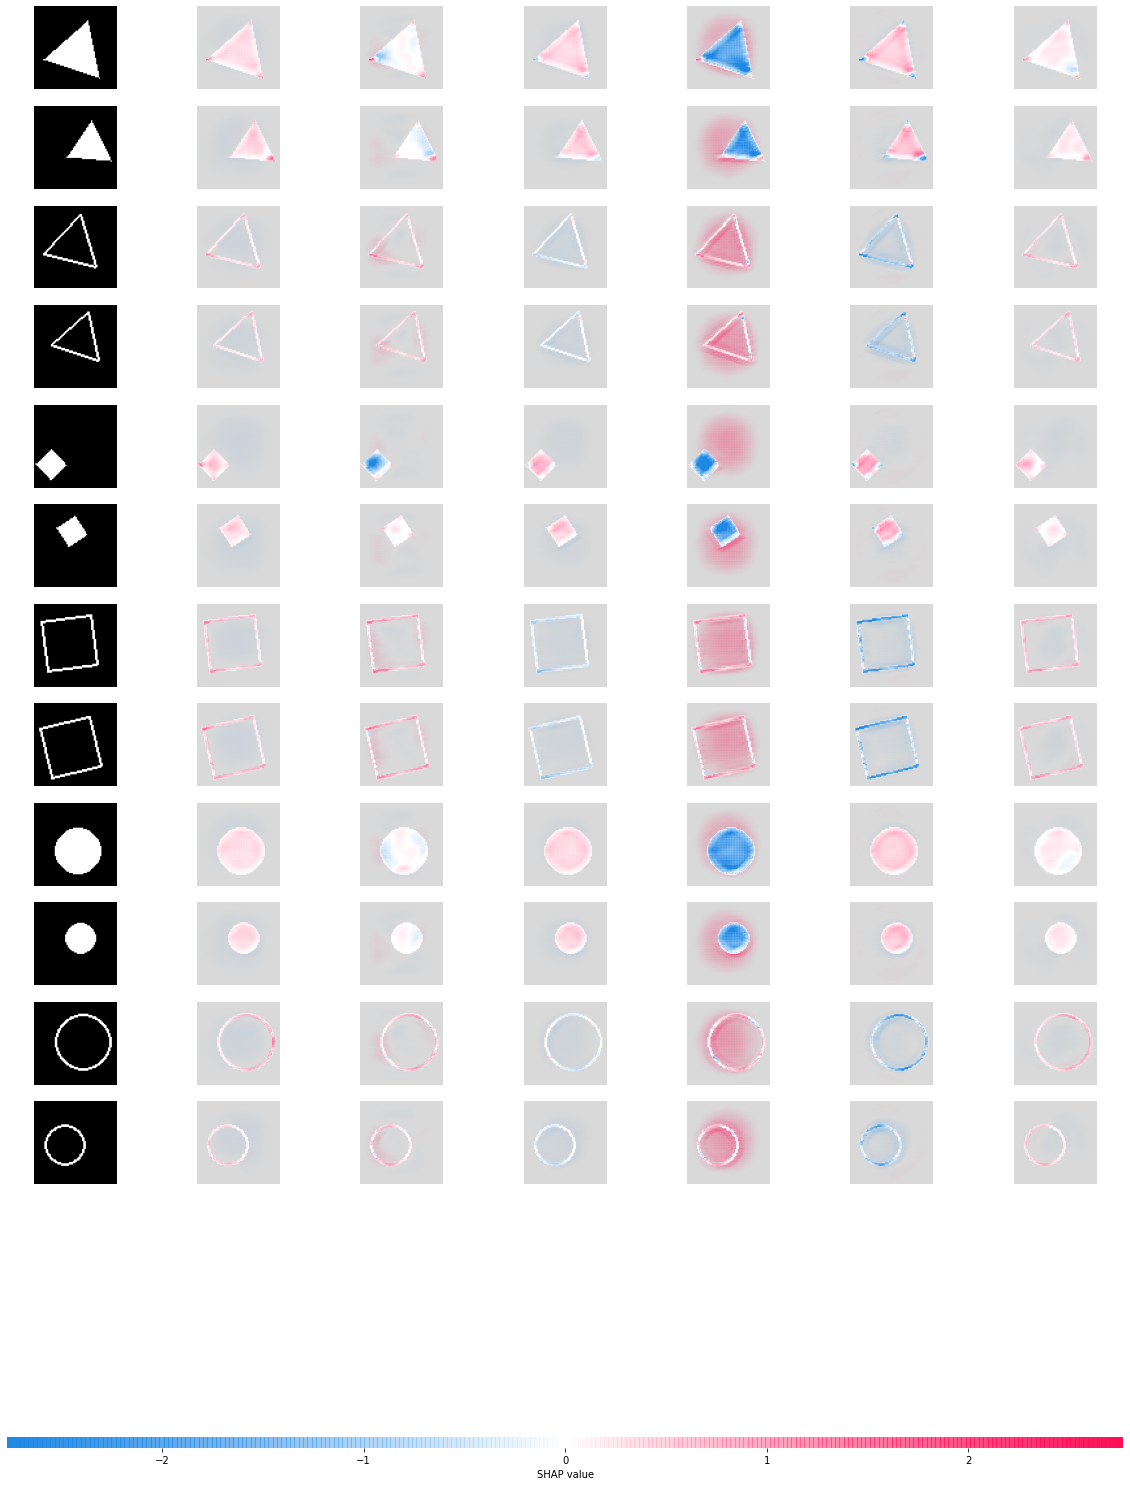

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(inp.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy)